## <center> 基础概念

### 一、相关概念说明

1. **度矩阵 $ D $**：
    - 度矩阵 $ D $ 是一个对角矩阵，其对角线元素 $ D_{ii} $ 表示节点 $ i $ 的度（即连接到节点 $ i $ 的边的数量）。

2. **邻接矩阵 $ A $**：
    - 邻接矩阵 $ A $ 是一个二值矩阵，其元素 $ A_{ij} $ 表示节点 $ i $ 和节点 $ j $ 之间是否存在边连接（存在边则为1，否则为0）。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.fft import fft, ifft

In [2]:
# Create a 5x5 grid graph
def create_graph():
    G = nx.grid_2d_graph(5, 5)
    A = nx.adjacency_matrix(G).todense()
    D = np.diag(np.sum(A, axis=1))
    L = D - A
    return G, L, A, D

G, L, A, D = create_graph()
pos = dict((n, n) for n in G.nodes())

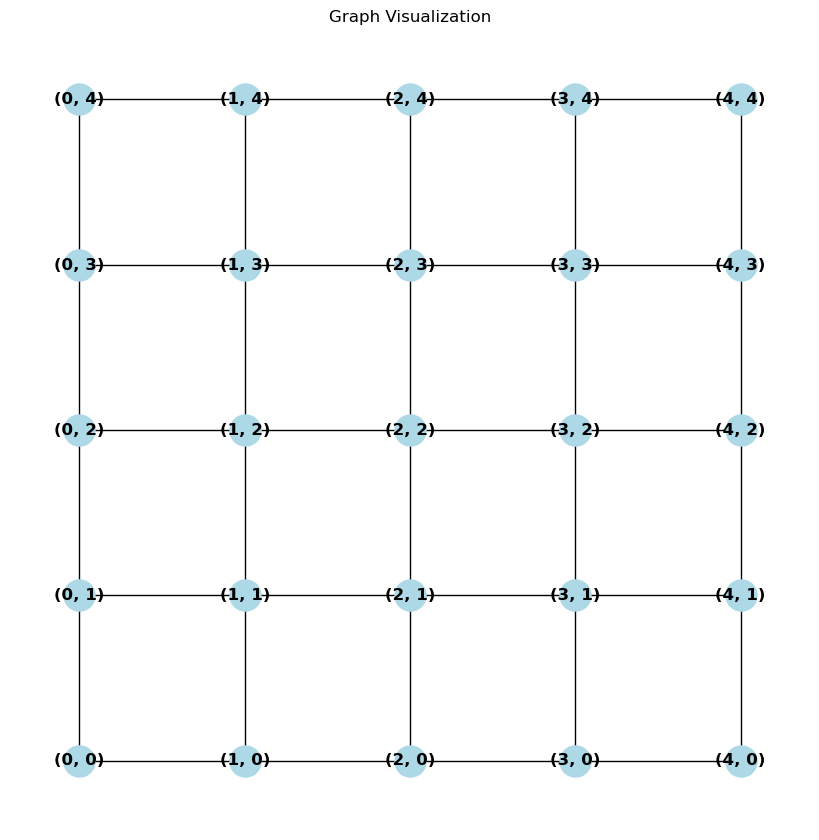

In [3]:
# visualize the graph
def visualize_graph(G):
    #pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=500, font_weight='bold')
    plt.title("Graph Visualization")
    plt.show()

visualize_graph(G)

### 二、拉普拉斯算子

#### 拉普拉斯算子的定义
$$
\Delta f(x) = \nabla · \nabla f(x) = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} + \frac{\partial^2 f}{\partial z^2} 
$$

#### 拉普拉斯算子的离散形式

##### 一维空间中的拉普拉斯算子

$$
\begin{aligned}
\Delta f(x) &= \frac{\partial^2 f}{\partial x^2} \\
&= f''(x)  \\
&\approx f'(x) - f'(x - 1) \\
&\approx [f(x + 1) - f(x)] - [f(x) - f(x - 1)] \\
&= f(x + 1) + f(x - 1) - 2f(x) \\
\end{aligned}
$$

也就是说，二阶导数近似于二阶差分，从这一角度来看拉普拉斯算子直观上表示函数 $ f $ 在当前点 $ x $ 的所有自由度上进行微小扰动后所获得的函数值的增益，这里有 2 个自由度，方向是 $ x $ 的 +1 和 -1 方向。

##### 二维空间中的拉普拉斯算子

$$
\begin{aligned}
\Delta f(x, y) &= \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} \\
&\approx [f(x + 1, y) + f(x - 1, y) - 2f(x, y)] + [f(x, y + 1) + f(x, y - 1) - 2f(x, y)] \\
&= f(x + 1, y) + f(x - 1, y) + f(x, y + 1) + f(x, y - 1) - 4f(x, y)
\end{aligned}
$$

二维空间中的拉普拉斯算子表征一个点 $ x $ 在 4 个自由度上微扰以后的函数增益，方向分别为 $(1,0), (-1,0), (0,1), (0,-1)$。这就是图像中的拉普拉斯卷积核。

另一个角度，拉普拉斯算子计算了周围点与中心点的梯度差。当$f(x,y)$受到扰动之后，其可能变为相邻的$f(x+1,y)、f(x-1,y)、f(x,y+1)、f(x,y-1)$其中之一，也就是说，拉普拉斯算子是对该点进行微小扰动后可能获得的总增益（或者说是总变化）

　　
**即：拉普拉斯算子是所有自由度上进行微小变化后所获得的增益**

### 三、图拉普拉斯算子

图拉普拉斯算子用于衡量图信号的平滑性。对于图结构数据，拉普拉斯算子可以表示为：
$$ L = D - A $$
其中，$ D $ 为度矩阵，$ A $ 为邻接矩阵。

### 四、图拉普拉斯算子的来源

对于有 $ N $ 个节点的网络，我们想要获得一个节点关于其邻居节点的增益，可以通过拉普拉斯算子来获得。拉普拉斯算子可以计算一个点到它所有自由度上的微小扰动，则通过图来表示就是任意一个节点 $ i $ 变化到节点 $ j $ 所带来的增益，考虑图中边的权值相等（简单说就是1）则有：

$$
\Delta f_i = \sum_{j \in N} (f_i - f_j)
$$

而如果边 $ E_{ij} $ 具有权重 $ w_{ij} $ 时，则有：

$$
\Delta f_i = \sum_{j \in N} w_{ij} (f_i - f_j)
$$

由于当 $ w_{ij} = 0 $ 时表示节点 $ i, j $ 不相邻，所以以上式可以简化为：

$$
\Delta f_i = \sum_{j \in N_i} w_{ij} (f_i - f_j)
$$

继续推导有：

$$
\Delta f_i = \sum_{j \in N} w_{ij} (f_i - f_j) = \sum_{j \in N} w_{ij} f_i - \sum_{j \in N} w_{ij} f_j = d_i f_i - w_i \cdot f
$$

其中：
- $ d_i = \sum_{j \in N} w_{ij} $ 是顶点 $ i $ 的度；
- $ w_i = (w_{i1}, \ldots, w_{iN}) $ 是 $ N $ 维的行向量；
- $ f =  (f_{1}, \ldots, f_{N})^T $ 是 $ N $ 维的列向量；
- $ w_i \cdot f $ 表示两个向量的内积。

对于所有的 $ N $ 个节点有：

$$
\Delta f = \begin{pmatrix} \Delta f_1 \\ \Delta f_2 \\ \vdots \\ \Delta f_N \end{pmatrix} = \begin{pmatrix} d_1 f_1 - w_1 \cdot f \\ d_2 f_2 - w_2 \cdot f \\ \vdots \\ d_N f_N - w_N \cdot f \end{pmatrix} = \begin{pmatrix} d_1 \\ d_2 \\ \vdots \\ d_N \end{pmatrix} f - \begin{pmatrix} w_1 \\ w_2 \\ \vdots \\ w_N \end{pmatrix} f = \text{diag}(d_i) f - W f = (D - W) f = L f
$$

这里的 $ D - W $ 就是图的拉普拉斯矩阵 (Graph Laplacian)，记作 $ L $。不难发现，当每条边的权重为 $ 1 $ 时，拉普拉斯矩阵有 $ L = D - W = D - A $。

拉普拉斯矩阵中的第 $ i $ 行实际上反应了第 $ i $ 个节点在对其他所有节点扰动时所产生的增益累积。直观上来讲，图拉普拉斯反应了当我们在节点 $ i $ 上施加一个势，这个势以哪个方向能够多顺畅的流向其他节点。谱聚类中的拉普拉斯矩阵可以理解为对图的一种矩阵表示形式。

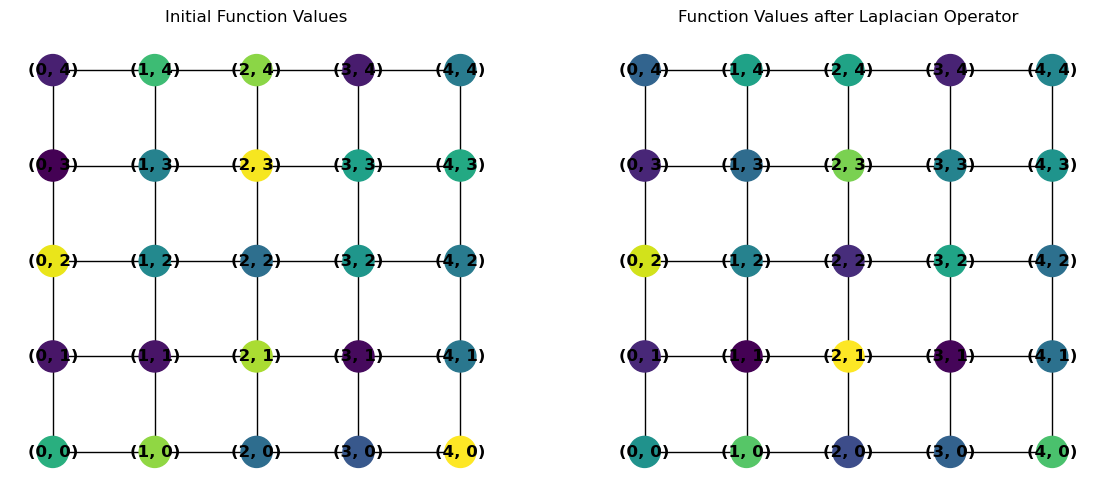

In [4]:
# Graph Laplacian Operator
def laplacian_operator(L, f):
    return L @ f

# eg
f = np.random.rand(G.number_of_nodes())
delta_f = laplacian_operator(L, f)

# visualize the function values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
nx.draw(G, pos, node_color=f, with_labels=True, node_size=500, font_weight='bold', cmap=plt.cm.viridis)
plt.title("Initial Function Values")

plt.subplot(1, 2, 2)
nx.draw(G, pos, node_color=delta_f, with_labels=True, node_size=500, font_weight='bold', cmap=plt.cm.viridis)
plt.title("Function Values after Laplacian Operator")

plt.show()

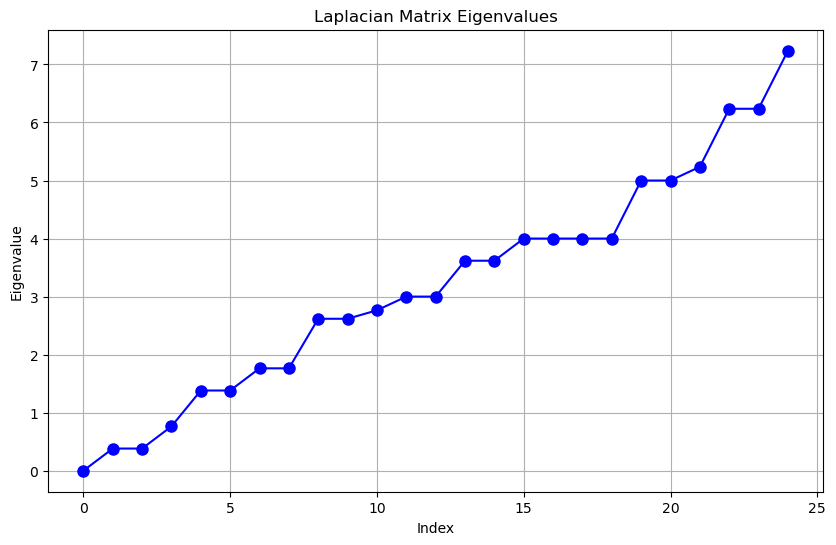

Eigenvectors are orthonormal: True


In [5]:
# Graph Fourier Transform
def compute_eigendecomposition(L):
    eigvals, eigvecs = np.linalg.eigh(L)
    return eigvals, eigvecs

def visualize_eigenvalues(eigvals):
    plt.figure(figsize=(10, 6))
    plt.plot(eigvals, 'bo-', markersize=8)
    plt.title("Laplacian Matrix Eigenvalues")
    plt.xlabel("Index")
    plt.ylabel("Eigenvalue")
    plt.grid(True)
    plt.show()

eigvals, eigvecs = compute_eigendecomposition(L)
visualize_eigenvalues(eigvals)

# orthonormality of eigenvectors
U, _ = np.linalg.qr(eigvecs)
identity_check = np.allclose(np.dot(U.T, U), np.eye(U.shape[0]))
print("Eigenvectors are orthonormal:", identity_check)

### 五、傅里叶变换

傅里叶变换将信号从时间域转换到频域。对于信号 $f(t)$，其傅里叶变换 $F(\omega)$ 定义为：

$$ 
F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-j\omega t} \, dt 
$$

逆傅里叶变换将频域信号转换回时间域：

$$ 
f(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} F(\omega) e^{j\omega t} \, d\omega 
$$

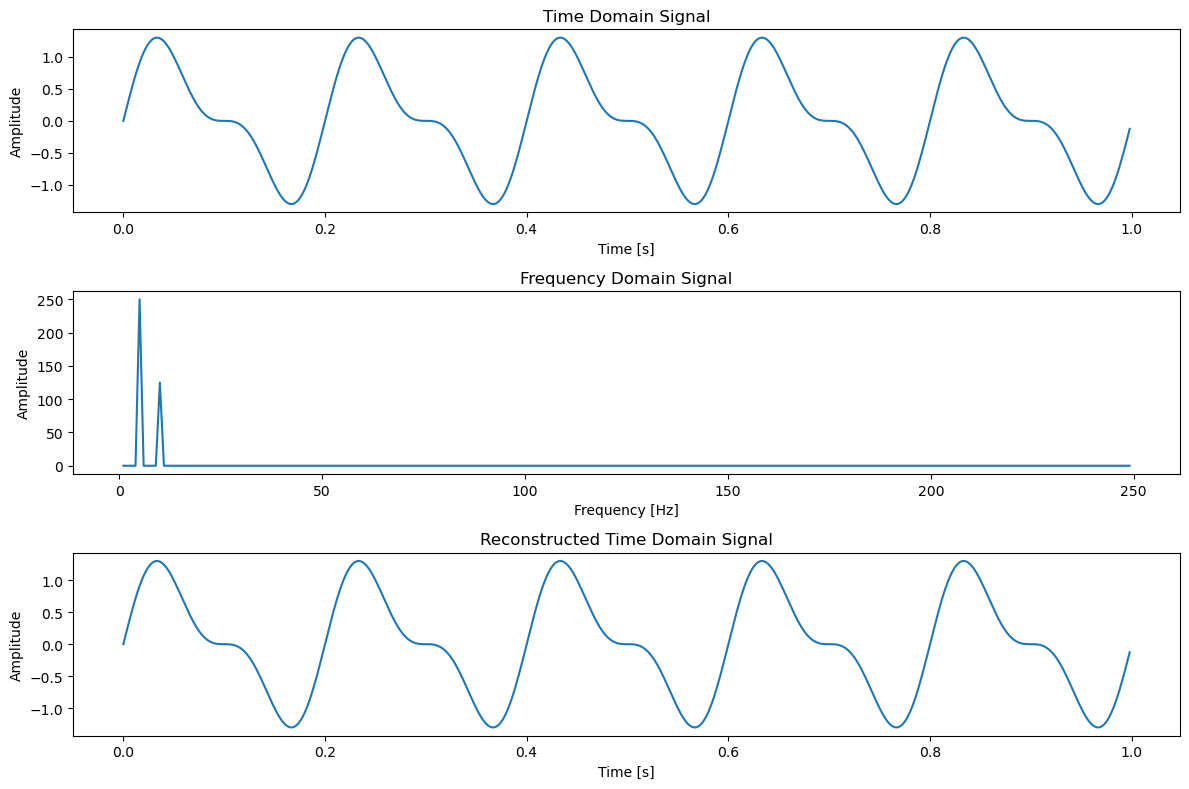

In [6]:
# Time Domain Signal
t = np.linspace(0, 1, 500, endpoint=False)
f_t = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)

# Graph F.T.
F_w = fft(f_t)

# Graph I.F.T.
f_t_reconstructed = ifft(F_w)

# time domain signal
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, f_t)
plt.title('Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# frequency domain signal
freqs = np.fft.fftfreq(len(t), t[1] - t[0])
mask = freqs > 0

plt.subplot(3, 1, 2)
plt.plot(freqs[mask], np.abs(F_w)[mask])
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

# reconstructed time domain signal
plt.subplot(3, 1, 3)
plt.plot(t, f_t_reconstructed.real)
plt.title('Reconstructed Time Domain Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


### 六、图傅立叶变换

在上述过程中，我们其实已经获得了拉普拉斯矩阵的特征向量，由于拉普拉斯矩阵是对称矩阵，其特征向量可以经归一化获得一个正交矩阵，以下是拉普拉斯矩阵的谱分解形式：
$$L = U \Lambda U^T, U^T U = I$$
此时$U^T$为在此图上的图论傅里叶变换矩阵。

**图傅里叶变换**：
   - 图信号 $x$ 可以表示为节点上的一个向量。其图傅里叶变换为：
     $$ \hat{x} = U^T x $$
   - 逆变换为：
     $$ x = U \hat{x} $$

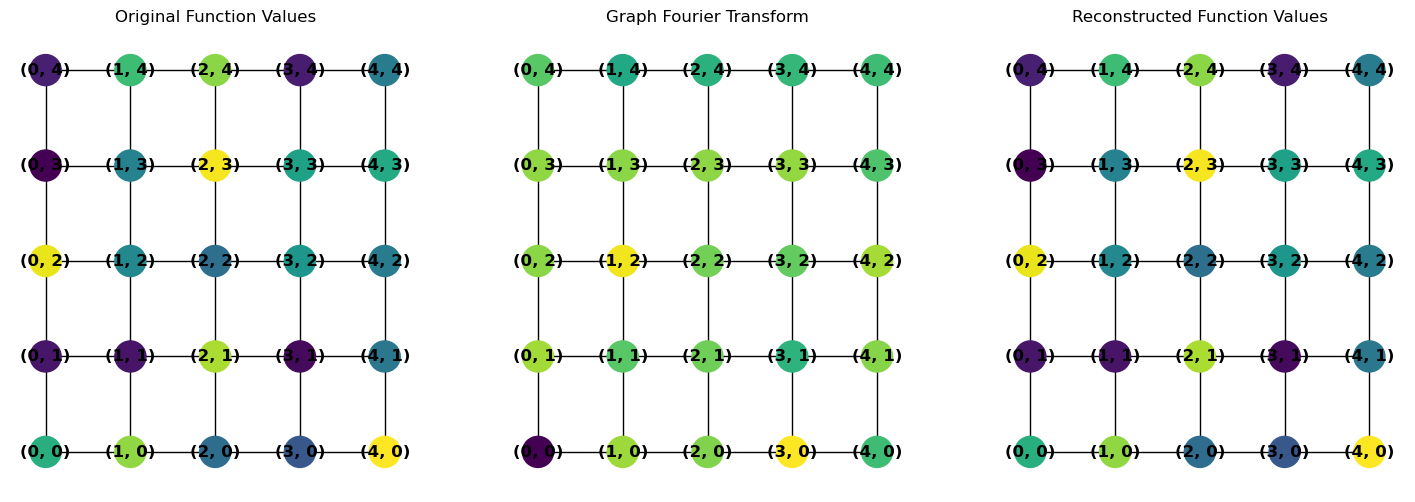

In [7]:
# FT/IFT on Graphs
def graph_fourier_transform(x, U):
    return U.T @ x

def inverse_graph_fourier_transform(x_hat, U):
    return U @ x_hat

f_hat = graph_fourier_transform(f, U)
f_reconstructed = inverse_graph_fourier_transform(f_hat, U)

# visualize the function values
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
nx.draw(G, pos, node_color=f, with_labels=True, node_size=500, font_weight='bold', cmap=plt.cm.viridis)
plt.title("Original Function Values")

plt.subplot(1, 3, 2)
nx.draw(G, pos, node_color=f_hat.real, with_labels=True, node_size=500, font_weight='bold', cmap=plt.cm.viridis)
plt.title("Graph Fourier Transform")

plt.subplot(1, 3, 3)
nx.draw(G, pos, node_color=f_reconstructed.real, with_labels=True, node_size=500, font_weight='bold', cmap=plt.cm.viridis)
plt.title("Reconstructed Function Values")

plt.show()

### 七、卷积

#### 空间域卷积

在经典信号处理中，两个信号 $f(t)$ 和 $g(t)$ 的卷积定义为：

$$ 
(f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t - \tau) \, d\tau 
$$


#### 卷积的傅里叶变换

我们要证明卷积在频域上是乘积。对卷积 $(f * g)(t)$ 进行傅里叶变换：

$$ 
\mathcal{F}\{(f * g)(t)\} = \mathcal{F}\left\{\int_{-\infty}^{\infty} f(\tau) g(t - \tau) \, d\tau \right\} 
$$

通过傅里叶变换的性质，我们可以写出：

$$ 
\mathcal{F}\{(f * g)(t)\} = \int_{-\infty}^{\infty} \left( \int_{-\infty}^{\infty} f(\tau) g(t - \tau) \, d\tau \right) e^{-j\omega t} \, dt 
$$

改变积分次序，得到：

$$ 
\mathcal{F}\{(f * g)(t)\} = \int_{-\infty}^{\infty} f(\tau) \left( \int_{-\infty}^{\infty} g(t - \tau) e^{-j\omega t} \, dt \right) d\tau 
$$

令 $u = t - \tau$，则 $du = dt$，积分限不变：

$$ 
\mathcal{F}\{(f * g)(t)\} = \int_{-\infty}^{\infty} f(\tau) \left( \int_{-\infty}^{\infty} g(u) e^{-j\omega (u + \tau)} \, du \right) d\tau 
$$

将 $e^{-j\omega (u + \tau)}$ 拆开：

$$ 
\mathcal{F}\{(f * g)(t)\} = \int_{-\infty}^{\infty} f(\tau) e^{-j\omega \tau} \left( \int_{-\infty}^{\infty} g(u) e^{-j\omega u} \, du \right) d\tau 
$$

内层积分是 $g(u)$ 的傅里叶变换 $G(\omega)$：

$$ 
\mathcal{F}\{(f * g)(t)\} = \int_{-\infty}^{\infty} f(\tau) e^{-j\omega \tau} G(\omega) \, d\tau 
$$

外层积分是 $f(\tau)$ 的傅里叶变换 $F(\omega)$：

$$ 
\mathcal{F}\{(f * g)(t)\} = G(\omega) \int_{-\infty}^{\infty} f(\tau) e^{-j\omega \tau} \, d\tau = G(\omega) F(\omega) 
$$

#### 总结

这表明，信号 $f(t)$ 和 $g(t)$ 的卷积在频域上等于它们各自傅里叶变换的乘积：

$$ 
\mathcal{F}\{(f * g)(t)\} = F(\omega) G(\omega) 
$$


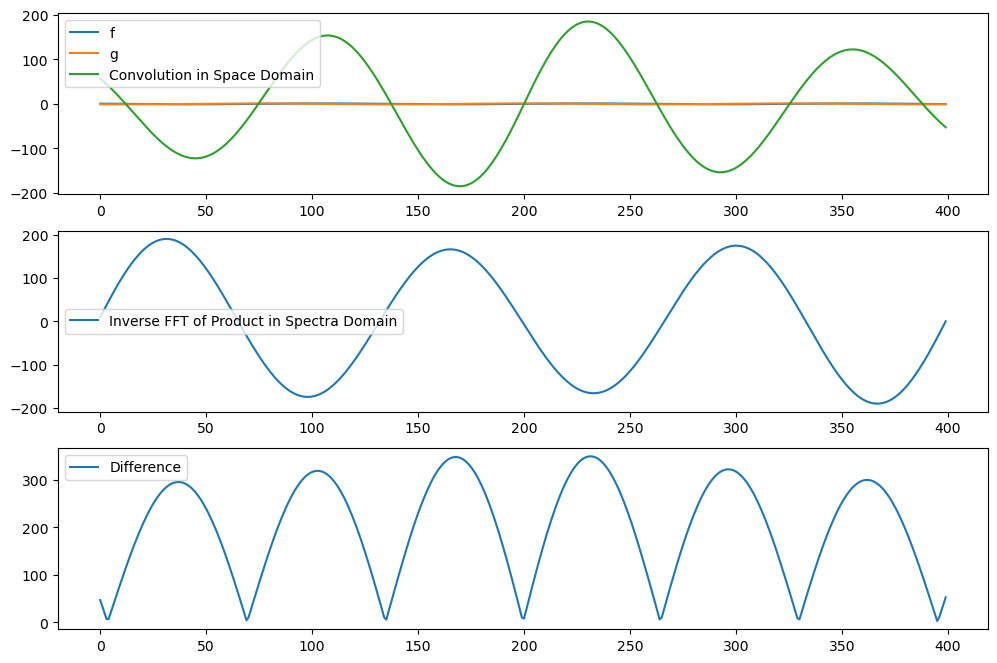

In [8]:
def verify_convolution_in_frequency_domain(f, g):
    conv_fg = np.convolve(f, g, mode='same')
    F_f = np.fft.fft(f)
    F_g = np.fft.fft(g)
    F_product = F_f * F_g
    conv_fg_from_F = np.fft.ifft(F_product)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(f, label='f')
    plt.plot(g, label='g')
    plt.plot(conv_fg, label='Convolution in Space Domain')
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(np.real(conv_fg_from_F), label='Inverse FFT of Product in Spectra Domain')
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(np.abs(conv_fg - np.real(conv_fg_from_F)), label='Difference')
    plt.legend()
    plt.show()

# Example signals for frequency domain convolution
x = np.linspace(-10, 10, 400)
f_x = np.sin(x)
g_x = np.cos(x)
verify_convolution_in_frequency_domain(f_x, g_x)

# There is a phase shift in the frequency domain convolution, I have not yet figured out why this is happening.

### 八、图卷积

1. **频(谱)域卷积**：
   - 在频域中，卷积操作为元素乘：
     $$ \hat{y} = \hat{g} \odot \hat{x} $$
     其中，$\hat{g}$ 是滤波器的频域表示，$\odot$ 表示元素乘。

2. **空间域卷积**：
   - 将频域结果变回空间域：
     $$ y = U \hat{y} = U (\hat{g} \odot \hat{x}) $$
   - 通过特征分解，将卷积操作表示为：
     $$ y = U g(\Lambda) U^T x $$
     其中，$g(\Lambda)$ 是滤波器在特征值 $\Lambda$ 上的表示。

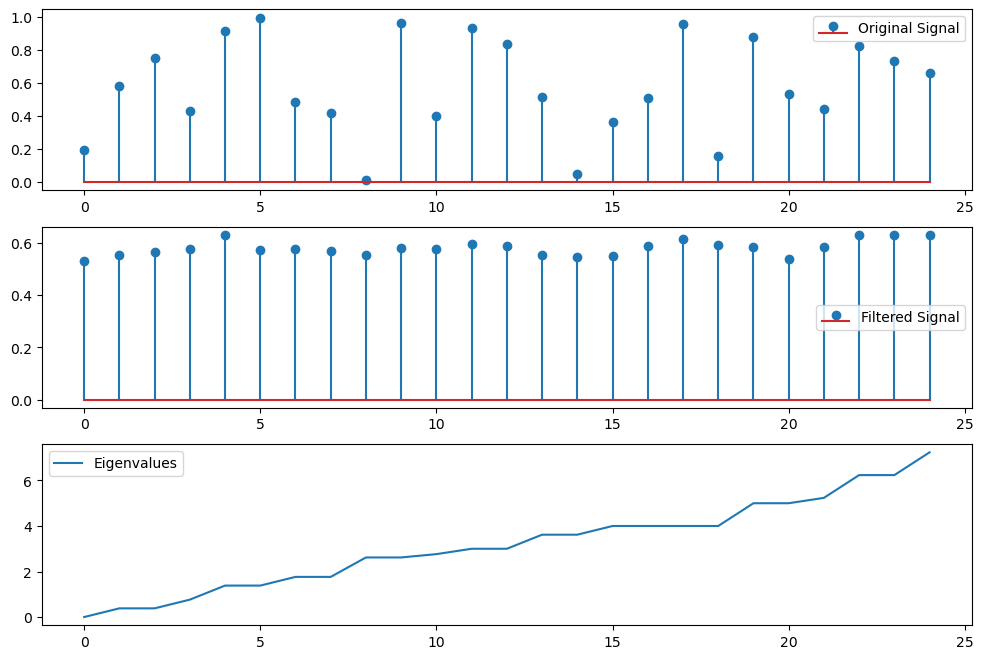

In [9]:
# Graph Convolution
def graph_convolution(G, L, eigvecs, eigvals):
    x = np.random.rand(len(G))
    g = np.exp(-eigvals)
    x_hat = graph_fourier_transform(x, eigvecs)
    y_hat = g * x_hat
    y = inverse_graph_fourier_transform(y_hat, eigvecs)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.stem(x, label='Original Signal')
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.stem(y, label='Filtered Signal')
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(eigvals, label='Eigenvalues')
    plt.legend()
    plt.show()

graph_convolution(G, L, eigvecs, eigvals)


## 九、图神经网络的一般框架

在数学上，我们可以将神经网络的一般框架定义如下：

初始：$H^0 = X$，节点的初始表征即为输入的节点属性矩阵。

对于第$k=1,2\cdots K$层的图神经网络：
$$a_v^k = \mathrm{AGGREGATE}^k\{H_u^{k-1}:u \in N(v) \}$$
$$H_v^k = \mathrm{COMBINE}^k\{H_v^{k-1},a_v^k\}$$

有了节点表征，我们就可以通过读出函数来将节点表征用于下游任务。